In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import keras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0703889, r0909802, r0716758, r0916443, r0822692</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [ ]:
#os.listdir('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Pili\AppData\Local\Temp/ipykernel_6352/3088546327.py", line 1, in <module>
    os.listdir('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022')
FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [5]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    'train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    'test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

ERROR! Session/line number was not unique in database. History logging moved to new session 50


'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [6]:
# The training set contains an identifier, name, image information and class label
train.head()

,name,class,img
id,,,
0,Mila_Kunis,2,"[[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4..."
1,Mila_Kunis,2,"[[[24, 35, 31], [25, 36, 32], [27, 36, 33], [2..."
2,Michael_Cera,0,"[[[111, 112, 106], [111, 112, 106], [112, 113,..."
3,Mila_Kunis,2,"[[[223, 223, 223], [223, 223, 223], [223, 223,..."
4,Michael_Cera,0,"[[[195, 195, 205], [195, 195, 205], [190, 192,..."


In [7]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

,img
id,
0,"[[[209, 210, 205], [208, 209, 204], [208, 209,..."


In [8]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,30,1
Michael_Cera,10,0
Mila_Kunis,30,2
Sarah_Hyland,10,0


Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [9]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [13]:
# parameter to play with 
# Set to 80x80 for the HOG feature extractor
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



ERROR! Session/line number was not unique in database. History logging moved to new session 52


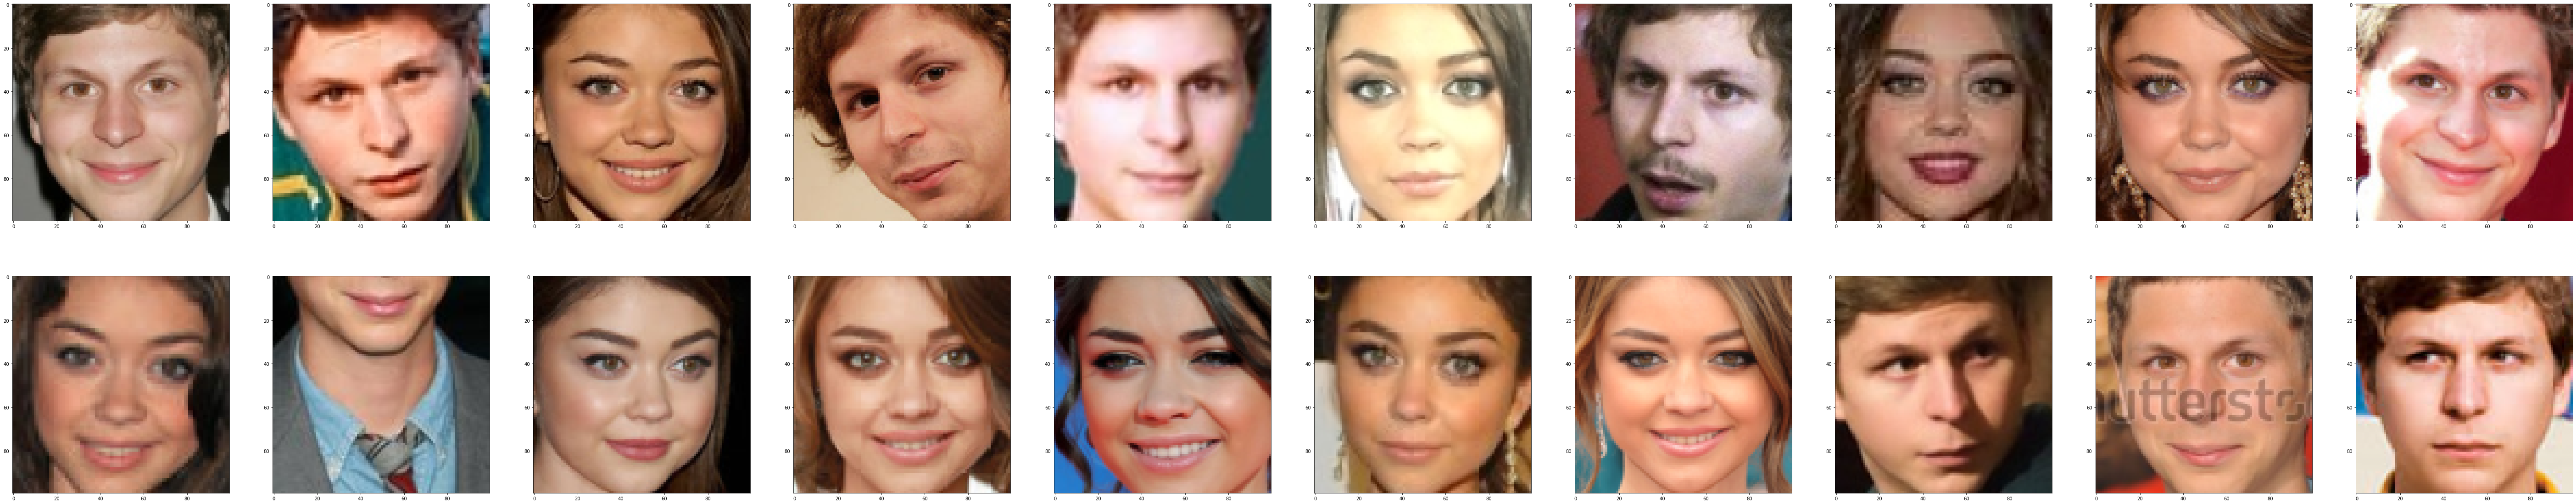

In [10]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

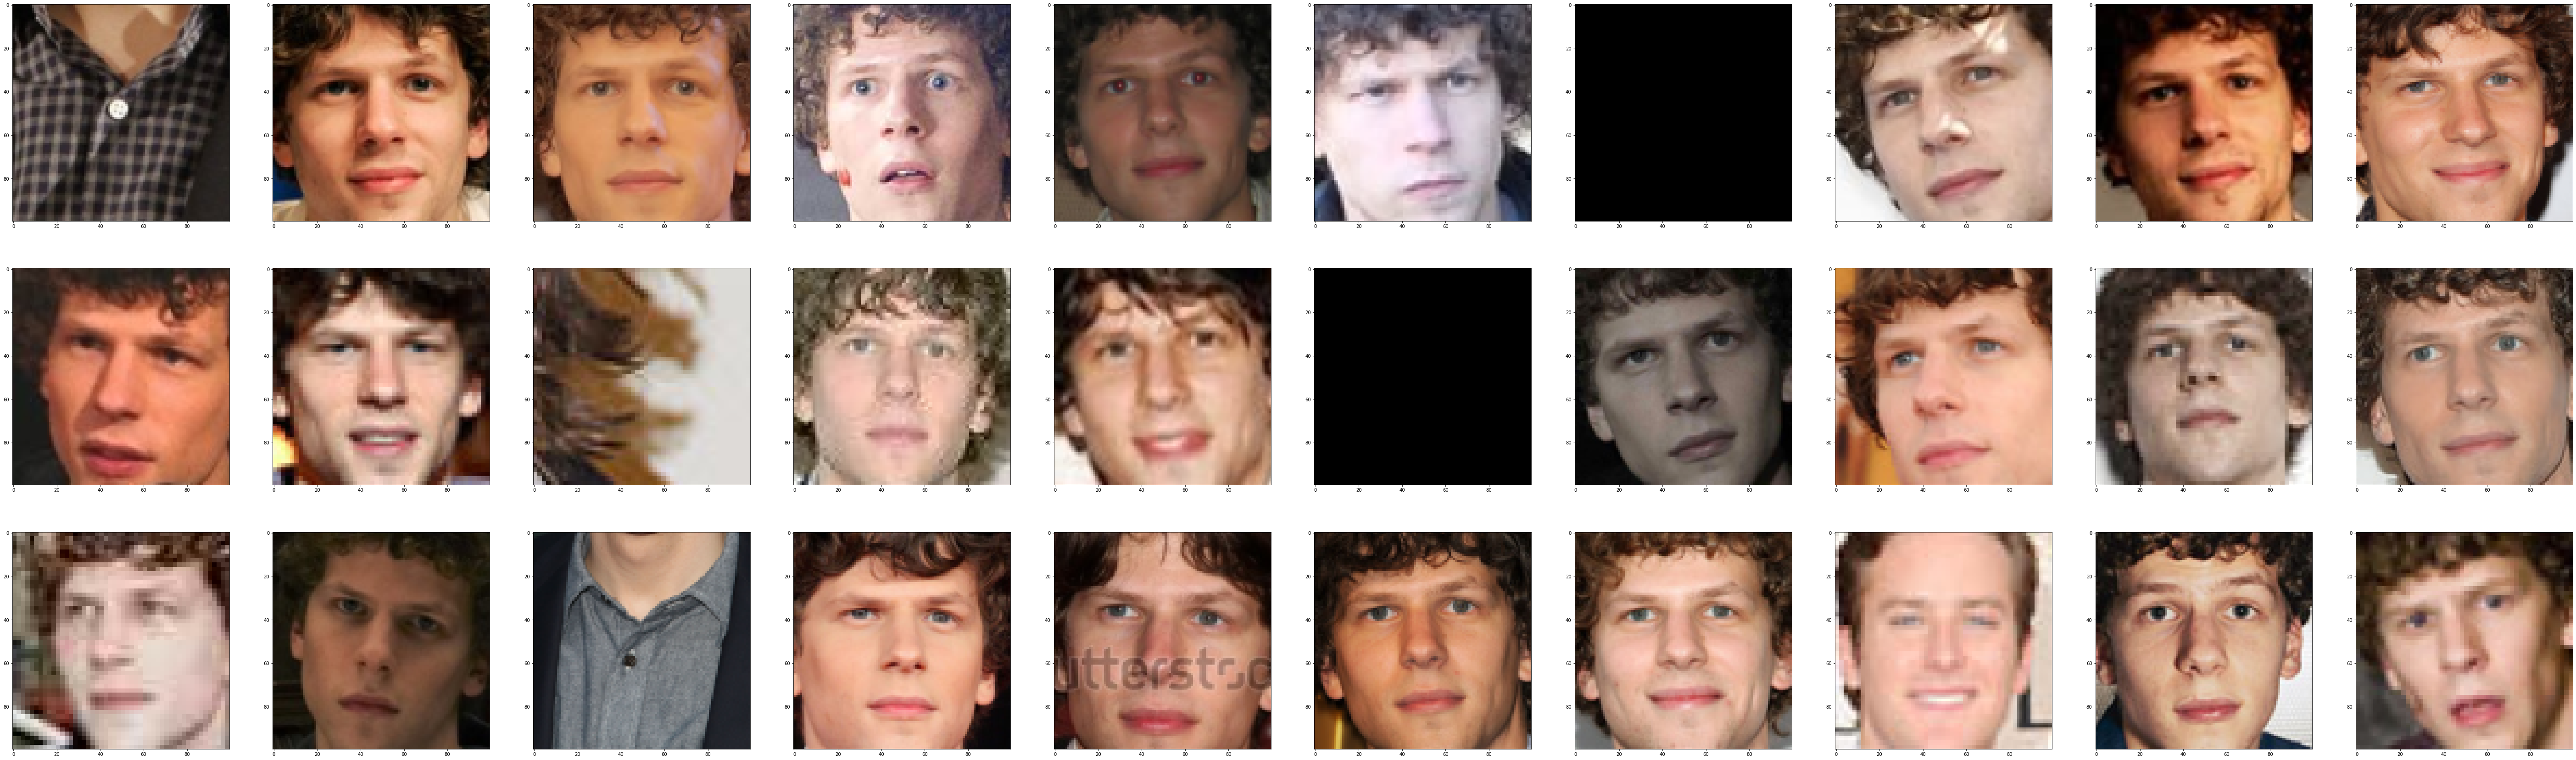

In [11]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

In [ ]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

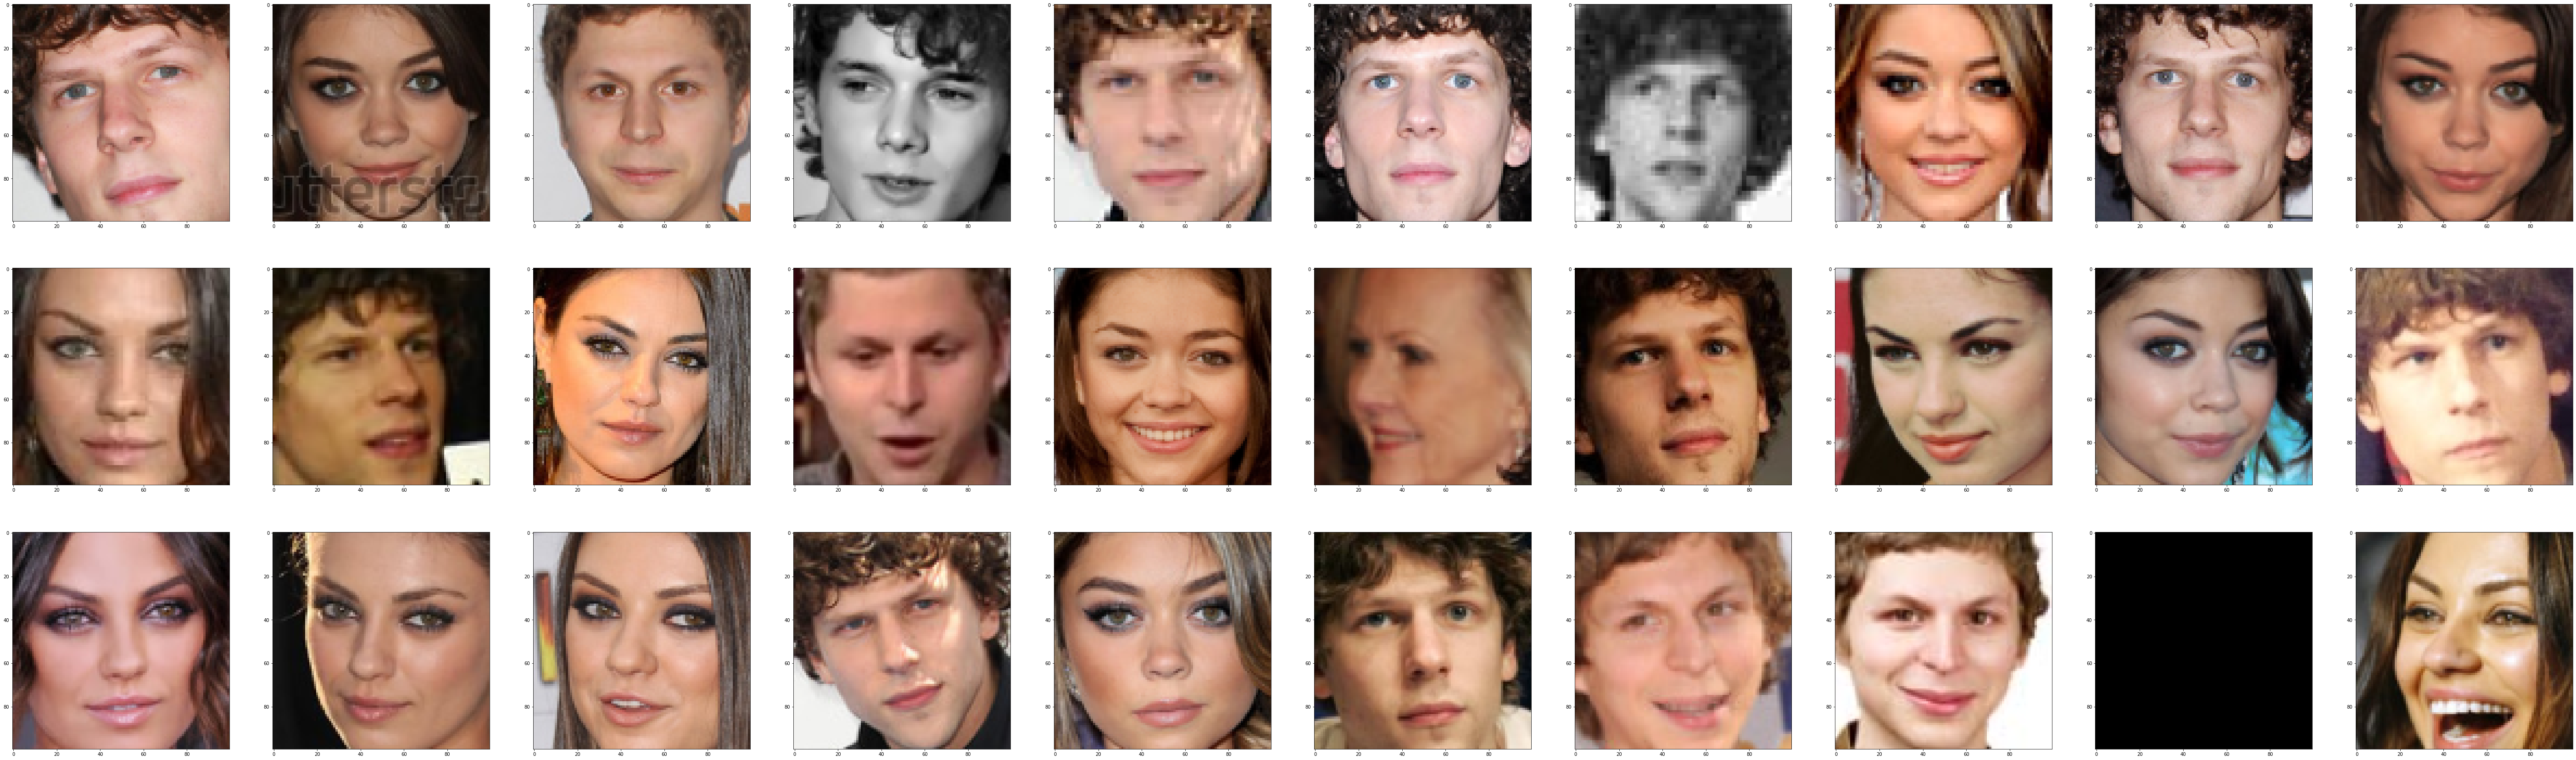

In [278]:
plot_image_sequence(test_X, n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

In [ ]:
# TODO: DELETE -> DON'T NEED IT
class Preprocessing:
    """Preprocessing of data for future"""
    
    def transform(self, X):
        nb_train_images = 80
        M = np.array(np.zeros([nb_train_images,10000]))
        for n in range(nb_train_images):
            Im = train_X[train_y][n]
            Im = rgb2gray(Im)
            A = np.asarray(Im).reshape(-1)
            M[n,:] = A
            return M
        
        
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform

HOG and SIFT are both very similar feature descriptors. 
However, the HOG feature extractor is used more frequently in classification problems than SIFT. The latter is used more in identificating specific objects. By this reason, we decided to implement the HOG feature extractor.


The HOG feature extractor counts occurences of gradient orientations in a localized portion of an image. The purpose of this technique to receive a better objects detection by focusing on the structure/shape of an object. This technique is widely used in computer vision and image processing, and was introducedin a research paper of Dala and Triggs in 2005.
This technique returns mostly sligtly better results than other edge descriptors because it also uses the magnitude and angle gradient to compute features, from which it generates an histogram.


In [ ]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import data
from skimage.color import (rgb2gray)
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """
    https://www.thepythoncode.com/article/hog-feature-extraction-in-python

    """
    
    def __init__(self, X):
        self.X = X
        

    def save_extract(self):
        """         
         Saves images converted by HOG extractor
         
         Returns
         -------
         list_img : Array of arrays representing the Hog_images
        """
        n = self.X.shape
        list_img = []
        
        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)
                    
            #prep_path = '/kaggle/working/prepped_data/'
            #if not os.path.exists(prep_path):
            #    os.mkdir(prep_path)
            
            #np.save(os.path.join(prep_path, 'train_X_HOG_{}.npy'.format(i)), hog_image)
            list_img.append(hog_image)
        
        return list_img

    def plot_extract(self):
        n = self.X.shape
        imgs_per_row = 10
        n_rows = 1 + int(n[0]/(imgs_per_row+1))
        n_cols = min(imgs_per_row, n[0])
        list_img = []
        
        # creating hog features
        f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)    

            list_img.append(hog_image)

            if n[0] == 1:
                ax.imshow(list_img[i])
            elif n_rows > 1:
                ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img[i])
            else:
                ax[int(i%n[0])].imshow(list_img[i])

        plt.show()  


In [ ]:
hog_model = HOGFeatureExtractor(train_X)



# Save the extracted data to /kaggle/working
hog_model.save_extract()


# plot the extracted data as hog
hog_model.plot_extract()

### 1.1.1. t-SNE Plots
t-Distributed Stochastic Neighbor Embedding (t-SNE) is not a mathematical technique as PCA, but a probabilistic one. It minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding [REWRITE - DEF FROM THE INTERNET]

In [279]:
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

# Attach img to dataframe
train['img_hog'] = [np.load('/kaggle/working/prepped_data/train_X_HOG_{}.npy'.format(index), allow_pickle=False) 
                for index, row in train.iterrows()]

train.head()


(80,)
(100, 100)
100
[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.001s...
[t-SNE] Computed neighbors for 80 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 139.778202


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.372459
[t-SNE] KL divergence after 1000 iterations: 0.312733
(80, 2)


<AxesSubplot:>

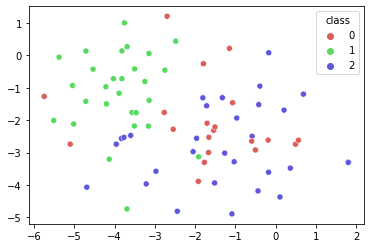

In [288]:
df = train['img_hog'] 

print(df.shape)
print(df[1].shape)


print(FACE_SIZE[1])

nb_train_images = 80 

M = np.array(np.zeros([nb_train_images, 10000]))
for n in range(nb_train_images):
    Im = df[n]
    A = np.asarray(Im).reshape(-1)
    M[n,:] = A


#tsne = TSNE(n_components=2, verbose=1, perplexity=30.0, learning_rate='warn', n_iter=1000, random_state=1)
tsne = TSNE(n_components=2, verbose=1, perplexity=30.0, learning_rate=100, n_iter=1000)

tsne_results = tsne.fit_transform(M)


print(tsne_results.shape)

TSNE1 = tsne_results[:,0].tolist()
TSNE2 = tsne_results[:,1].tolist()

sns.scatterplot(x=TSNE1, y=TSNE2, hue=train['class'], palette=sns.color_palette("hls", 3), data=df, legend="full")


### 1.1.2. Discussion
#### a) How to make your descriptor behave well in different circumstances (e.g. image with different lighting)?
By simply **normalizing** the images with a 'L2' parameter, we **avoid brightness, contrast or other illumination effects**. This was done by adding `block_norm= ‘L2’` as a parameter of the HOG feature extractor. We could also have used L1 and L2-Hys as volunteering parameters. L2-Hys is sometimes used to reduce noise with the help of a L2-norm.


#### b) Visualize Feature Representation: [TODO]
t-SNE : This method classifies the images into clusters with similarities. Given N points -  $x_1,x_2,…,x_N$ in any dimension, t-SNE will compute the probability  pi,
j  the probability of similarity of  $x_i$  and  $x_j$ . The similarity is calculated based on the t-distribution. 
In practice given a cluster of N points t-SNE helps in finding clusters in which there exists similarity in the data points.

The parameters for t-SNE are number of components =2, perplexity=40 which governs the number of nearest neighbours, learning rate=200, if this is too high the data will look like a ball with equispaced nearest neighbours.     
number of iterations for optimization = 300. We also chose verbose = 1. The other various parameters were chosen to be default namely early_exaggeration, n_iter_without_progress, min_grad_norm,random_state=None, method='barnes_hut'.


#### c) How does this feature compare to your previous grabbing task in the individual assignment?
The HOG feature extractor is a gradient based method and is generally known as a more robust method than the one we used in the individual assignment. In the individual assignment, the object grabbing was based on a **threshold of a particular colour**. The HOG feature extractor in contrary, uses the **magnitude and slope** to compute features. It is computed by dividing an entire image into smaller cells an summing up their gradients over every pixel within each cell in an image.


#### d) Did you need specific pre-processing steps before computing these feature descriptors on your images (which ones and why)?
First of all, we convert the images to a **grayscale** as a basement for the following steps. Then, before processing, the images have been **resized**. In the paper of Dalal and Triggs, dimensions 128x64 were advised. However, the size depends on the application. In the notebook, the images were already resized to 100x100 pixels. We tried to resize the images to 80x80, bit it gave worser results on the t-sne, so we kept te original proposed size. This was all done in the HAARpreprocessing phase.
Further, we **normalized** the images with a 'L2' parameter, **to avoid brightness, contrast or other illumination effects**. Other possible paramaters we could have used are L1 and L2-Hys. Finally, in order to take a few neighboring pixels into account instead of single pixel values as its true value, we performed a **Gaussian filtering**.

#### e) Did the visualisation show good discriminative and robustness properties? [TODO]
Yes the t-SNE is able to show 3 major clusters of Jesse, Mila and the look alike. The HOG is able to show the major features of a face like nose, boundary, eyes etc. This is only possible for 
images with distinct values in pixels. For the black images which are outliers this is not possible.


#### f) Discussing missing values

In class 1 and 2, several black images appear. This means that the black images only contain 0 values, thus no information. Consequently, we can remove those images since they do not help our algorithm in classifying the faces correctly. 

Thereby, a few images which do not contain a face, are added to the training set.
In statistics, it is advised noy to throw away outliers unless we surely know that they are measurement errors. This is why we decided to keep these images in our dataset. Thereby, they can probably help us not to overfit certain parameters of a face. 

## 1.2. Baseline 2: PCA feature extractor
...

In [ ]:
def Preprocess(X):
    n = X.shape[0]
    M = np.zeros([n,10000])
    for i in range(n):
        img = X[i]
        converted = np.float32(img)
        gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
        A = np.asarray(blur).reshape(-1)
        M[i,:] = A
    return M

In [ ]:
from sklearn.decomposition import PCA
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.estimator = PCA(n_components=self.n_components, svd_solver="randomized", whiten=True)
        
    def fit(self,X):
        self.estimator.fit(X)
        components = self.estimator.components_
        return components
        
    def transform(self, X):
        Xc = self.estimator.transform(X)
        return Xc
        

    def inverse_transform(self, X):
        Xc = self.estimator.inverse_transform(X)
        return Xc

### 1.2.1. Eigenface Plots
...

In [289]:
def plot_gallery(title, images, n_col=3, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(
            comp.reshape((100,100)),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)

In [290]:
## Convert images to 2D matrix
M_pca = Preprocess(train_X)
    
# Mean substraction
# M = M - M.mean(axis=0)
M_pca = M_pca - M_pca.mean(axis=1).reshape(M_pca.shape[0], -1)

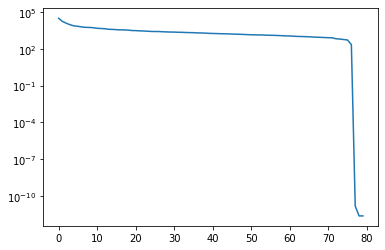

In [291]:
u, s, vh = np.linalg.svd(M_pca,full_matrices=False)
plt.semilogy(s)

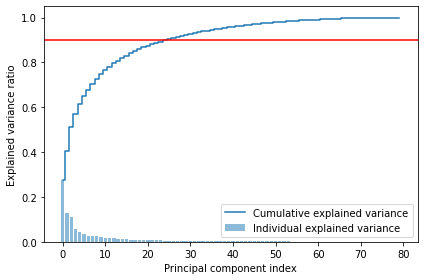

In [292]:
#Nb non-zero singular values: 80% -> 6 components
E = PCAFeatureExtractor(M_pca.shape[0])
comp = E.fit(M_pca)
X= E.transform(M_pca)
exp_var_pca = E.estimator.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
perc = 0.9
N = [ n for n,i in enumerate(cum_sum_eigenvalues) if i>perc ][0]

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=perc, color='r', linestyle='-')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

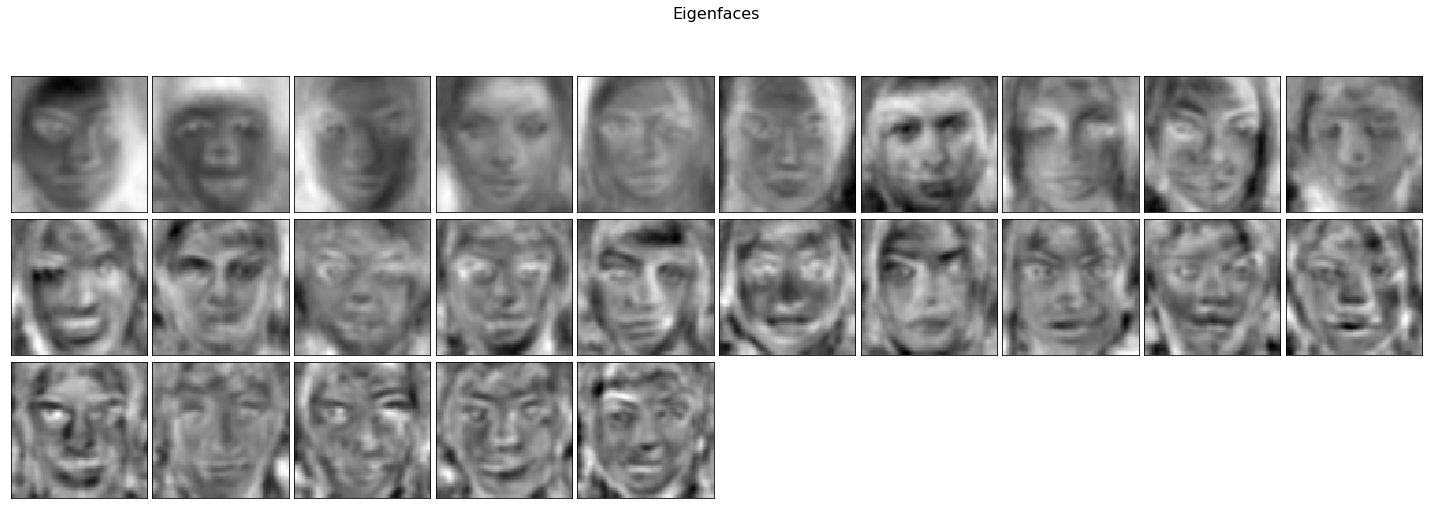

In [294]:
E = PCAFeatureExtractor(N)
comp = E.fit(M_pca)
X = E.transform(M_pca)
plot_gallery("Eigenfaces" , comp,10,8)
plt.show()

### 1.2.2. Feature Space Plots
...

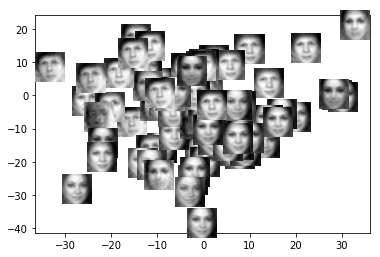

In [295]:
E2 = PCAFeatureExtractor(2)
comp2 = E2.fit(M_pca)
X2 = E2.transform(M_pca)
Reconstruction = E2.inverse_transform(X2)
Y = np.matmul(M, comp2[:2,:].T)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure()
axes = fig.add_subplot(111)
axes.scatter(Y[:,0],Y[:,1])
for i in range(M.shape[0]):
    im = OffsetImage(Reconstruction[i,:].reshape((100,100)),zoom=0.3,cmap=plt.cm.gray)
    ab = AnnotationBbox(im, (Y[i,0],Y[i,1]), frameon=False)
    axes.add_artist(ab)

In [296]:
from IPython.display import clear_output
import time
##Projection
# mean = M.mean(0)
# mean = X[]
# output = mean
for i in range(1,80):
    print(i)
    E2 = PCAFeatureExtractor(i)
    comp2 = E2.fit(M_pca)
    X2 = E2.transform(M_pca)
    Reconstruction = E2.inverse_transform(X2)
    plt.imshow(Reconstruction[10,:].reshape(100,100),cmap=plt.cm.gray)
    plt.show()
    clear_output(wait=True)
    time.sleep(1)

KeyboardInterrupt: 

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
Best classifiers with HOG as base:
- SVM
- Random Forest
- KNN

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

HIER VERDERDOEN -> HOG WORDT NIET GEIMPLEMENTEERD

In [ ]:
# hog features
X = train[['img', 'img_hog']]
y = train['class']


# 1 Train-validation set
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size=0.2, random_state=0)

print(M.shape)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

print(X.shape)
print(y.shape)

DT_model = DecisionTreeClassifier()

DT_model.fit(X_train, y_train)
DT_predict = DT_model.predict(X_test)
DT_score = DT_model.score(X_test,y_test)

DT_score

In [ ]:
from sklearn.tree import DecisionTreeClassifier

class DecisionTree:
    """TODO: this classifier is under construction."""
    def __init__(self):
        self.model = DecisionTreeClassifier()
        
    def fit(self, X, y):
        self.model.fit(X, y)
                
    def predict(self, X):
        #self.predict = self.model.predict(X)
        return self.model.predict(X)
        
    def score(self, X, y):
        return self.model.score(X, y)

In [ ]:
from sklearn import svm

class SVM:
    """TODO: this classifier is under construction."""
    def __init__(self):
        self.model = svm.SVC()
        
    def fit(self, X, y):
        self.model.fit(X, y)
                
    def predict(self, X):
        #self.predict = self.model.predict(X)
        return self.model.predict(X)
        
    def score(self, X, y):
        return self.model.score(X, y)

In [ ]:
DT = DecisionTree()
DT.fit(X_train, y_train)
DT.predict(X_test)
DT.score(X_test, y_test)

prediction = DT.predict(X_test)
print(prediction)
#print(DT.predict(X_test))
print(y_test)

In [ ]:
SVM_model = SVM()
SVM_model.fit(X_train, y_train)
SVM_model.predict(X_test)
SVM_model.score(X_test, y_test)

prediction = DT.predict(X_test)
print(prediction)
print(y_test)

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    
    def fit(self, X, y):
        raise NotImplmentedError
        
    def predict(self, X):
        raise NotImplmentedError

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
# HOG
from sklearn.tree import DecisionTreeClassifier

# We are training on all the data.
#feature_extractor = IdentityFeatureExtractor() 
feature_extractor_train = HOGFeatureExtractor(train_X)
feature_extractor_test = HOGFeatureExtractor(test_X)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
nb_train_images = 80 

M_hog_train = np.array(np.zeros([nb_train_images, 10000]))
for n in range(nb_train_images):
    img = hog_train[n]
    A = np.asarray(img).reshape(-1)
    M_hog_train[n,:] = A


    

# TRANSFORM TEST SET
nb_test_images = 1816

M_hog_test = np.array(np.zeros([nb_test_images, 10000]))
for n in range(nb_test_images):
    img = hog_test[n]
    A = np.asarray(img).reshape(-1)
    M_hog_test[n,:] = A
    
print(M_hog_test)

In [272]:
# PCA
# convert original data to the features

Train = Preprocess(train_X)
PCA_FE = PCAFeatureExtractor(N)
comp = PCA_FE.fit(Train)
X_pca_train = PCA_FE.transform(Train)
Test = Preprocess(test_X)
X_pca_test = PCA_FE.transform(Test)

In [274]:
X_pca_test.shape

(1816, 25)

In [ ]:
DT_model = DecisionTreeClassifier()
DT_model.fit(M_hog_train, train_y)
DT_predict = DT_model.predict(M_hog_test)

In [ ]:
SVM_model = svm.SVC()
SVM_model.fit(M_hog_train, train_y)
SVM_predict = SVM_model.predict(M_hog_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(random_state=0, max_iter=1000)
LR_model.fit(M_hog_train, train_y)
LR_predict = LR_model.predict(M_hog_test)

In [275]:
# SAME MODEL BUT WITH PCA
from sklearn.multiclass import OneVsRestClassifier


LR_model_pca = LogisticRegression()
ovr = OneVsRestClassifier(LR_model_pca)
ovr.fit(X_pca_train, train_y)
LR_predict_pca = ovr.predict(X_pca_test)

#LR_model_pca = LogisticRegression(random_state=0, max_iter=1000)
#LR_model_pca.fit(X_pca_train, train_y)
#LR_predict_pca = LR_model_pca.predict(X_pca_test)



In [ ]:
from sklearn.linear_model import Perceptron

PE_model = Perceptron(tol=1e-3, random_state=0)
PE_model.fit(M_hog_train, train_y)
PE_predict = PE_model.predict(M_hog_test)

In [ ]:
# Ridge Classifier
from sklearn.linear_model import RidgeClassifier

RC_model = RidgeClassifier()
RC_model.fit(M_hog_train, train_y)
RC_predict = RC_model.predict(M_hog_test)

In [ ]:
#HYPERPARAMETER TUNING KNNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)


knn_2 = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)


#Fit the model
best_model = clf.fit(M_hog_train, train_y)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

#neigh_model = KNeighborsClassifier(n_neighbors=3)
#neigh_model.fit(M_hog_train, train_y)
#neigh_predict = neigh_model.predict(M_hog_test)

In [ ]:
neigh_model = KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=1)
neigh_model.fit(M_hog_train, train_y)
neigh_predict = neigh_model.predict(M_hog_test)

In [ ]:
# checken how many from each class
Ty = DT_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = SVM_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = neigh_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = LR_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = PE_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [ ]:
Ty = RC_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

In [276]:
Ty = LR_predict_pca.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(0,)
(750,)
(1066,)


[[[[  9  10   5]
   [ 19  17  14]
   [ 19  15  12]
   ...
   [ 34  19   9]
   [ 38  23  14]
   [ 53  34  27]]

  [[ 18  16  12]
   [ 21  17  14]
   [ 22  17  13]
   ...
   [ 38  23  14]
   [ 43  28  19]
   [ 46  27  21]]

  [[ 41  36  32]
   [ 24  18  14]
   [ 24  17  12]
   ...
   [ 34  20  12]
   [ 38  24  15]
   [ 54  34  21]]

  ...

  [[220 222 221]
   [220 222 221]
   [219 221 220]
   ...
   [180 134 118]
   [178 131 115]
   [171 126 110]]

  [[220 222 221]
   [220 222 221]
   [219 221 220]
   ...
   [177 131 114]
   [175 129 113]
   [166 121 106]]

  [[219 221 220]
   [220 222 221]
   [220 222 221]
   ...
   [175 130 112]
   [168 123 106]
   [161 113  99]]]


 [[[ 22  15  12]
   [ 21  16  12]
   [ 17  12   8]
   ...
   [ 17  12   9]
   [ 21  13   9]
   [ 19  12   7]]

  [[ 21  14  11]
   [ 20  15  11]
   [ 19  14  10]
   ...
   [ 17  12   9]
   [ 19  11   8]
   [ 19  11   8]]

  [[ 18  13  10]
   [ 18  13   9]
   [ 20  12   9]
   ...
   [ 17  11   8]
   [ 18  10   7]
   [ 17   9

In [ ]:
# evaluate performance of the model on the training set
#train_y_star = model(train_X)

#train_y_star = model(X_train)
#train_y_star = model(M_hog_train)

#model(X_train)

#"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
#    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
#test_y_star = model(X_test)
test_y_star = LR_predict

print(test_y_star)

In [ ]:
test_y_star = SVM_predict

print(test_y_star)

In [ ]:
test_y_star = neigh_predict

print(test_y_star)

In [ ]:
test_y_star = LR_predict

print(test_y_star)

In [ ]:
test_y_star = PE_predict

print(test_y_star)

In [ ]:
test_y_star = RC_predict

print(test_y_star)

In [261]:
test_y_star = LR_predict_pca

print(test_y_star)

[1 2 1 ... 1 1 1]


# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission_LR_PCA.csv')


#prep_path = '/kaggle/working/'
#if not os.path.exists(prep_path):
#       os.mkdir(prep_path)
            
#np.save(os.path.join(prep_path, 'train_sumbission.npy'), submission)

#print(submission)

# 6. Discussion
...

In summary we contributed the following: 
* 
